In [1]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from typing import List, Any
import os
import pyproj
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as img
import cmocean
import cmocean.cm as cmo

import sgl_processor_v03 as sgl
import sgl_utils
import geopandas as gpd

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd

settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.


In [25]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
drains18["year"] = 18
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
drains19["year"] = 19
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_5.shp"))

lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
drains20["year"] = 20
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [4]:
coll = coll19
dmgs = dmgs19
settings = settings19
lakeextent = lakeextent19

In [64]:
drains = pd.concat([drains18[(drains18["criteria"].isin(positive_drains18))],
                    drains19[(drains19["criteria"].isin(positive_drains19))],
                    drains20[(drains20["criteria"].isin(positive_drains20))]
                    ]).reset_index() # type: ignore
drains.set_crs(drains18.crs)
drains.head()

,level_0,index,criteria,window,lake id,type,run,name,area,date-0,...,start-0,end-0,date-1,sat-1,start-1,end-1,day diff,valid,geometry,year
0,10,129,tile-1822018-12-26562019-01-05S2S2drain,0,56.0,drain,3,tile-182,2700.0,2018-12-26,...,2018-12-21,2018-12-31,2019-01-05,S2,2018-12-31,2019-01-10,10,1,"MULTIPOLYGON (((2554470.000 -349110.000, 25545...",18
1,11,137,tile-1822019-01-303002019-02-07L8L8shrink,0,300.0,shrink,10,tile-182,99900.0,2019-01-30,...,2019-01-26,2019-02-03,2019-02-07,L8,2019-02-03,2019-02-11,8,1,"POLYGON ((2573160.000 -400260.000, 2573250.000...",18
2,12,147,tile-1822019-02-145792019-02-24S2S2shrink,0,579.0,shrink,12,tile-182,99900.0,2019-02-14,...,2019-02-09,2019-02-19,2019-02-24,S2,2019-02-19,2019-03-01,10,1,"POLYGON ((2573220.000 -401310.000, 2573310.000...",18
3,13,162,tile-1822019-01-303002019-02-07L8L8shrink,1,300.0,shrink,10,tile-182,12600.0,2019-01-30,...,2019-01-26,2019-02-03,2019-02-07,L8,2019-02-03,2019-02-11,8,1,"POLYGON ((2573190.000 -400290.000, 2573250.000...",18
4,14,164,tile-1822019-02-145792019-02-24S2S2shrink,1,579.0,shrink,12,tile-182,12600.0,2019-02-14,...,2019-02-09,2019-02-19,2019-02-24,S2,2019-02-19,2019-03-01,10,1,"MULTIPOLYGON (((2573220.000 -401340.000, 25732...",18


In [80]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


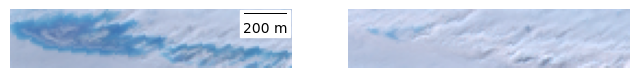

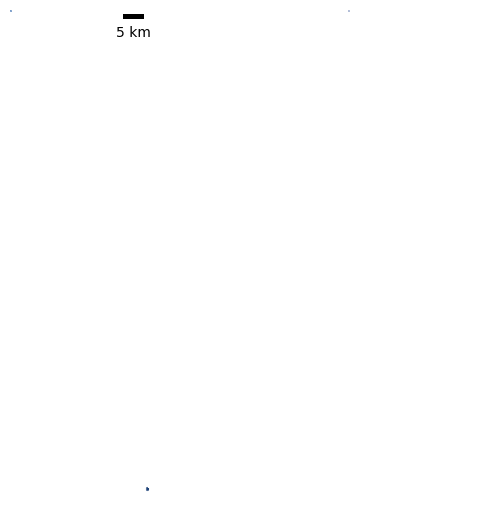

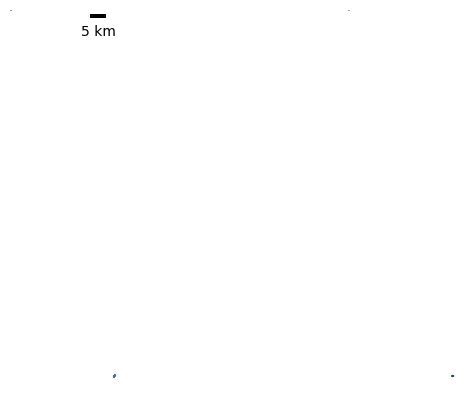

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


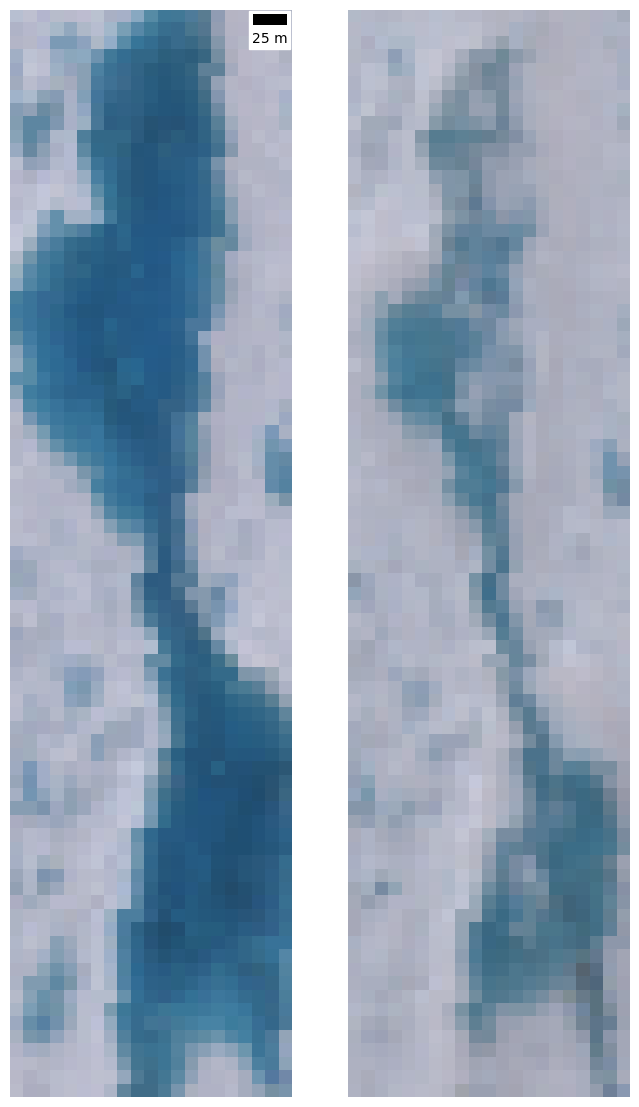

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


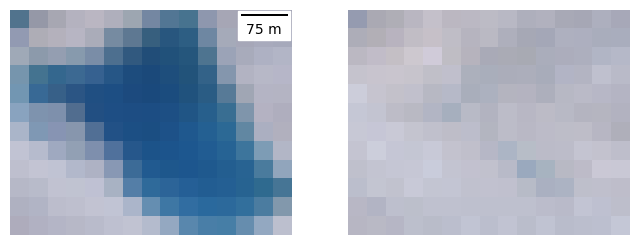

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


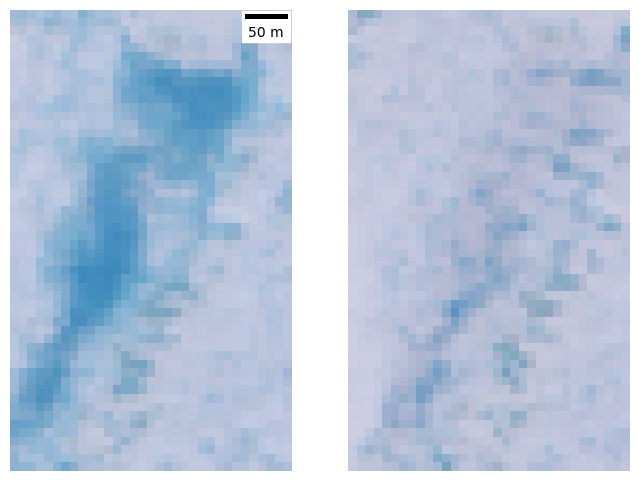

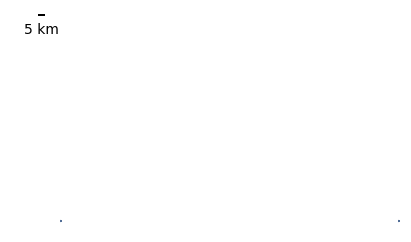

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


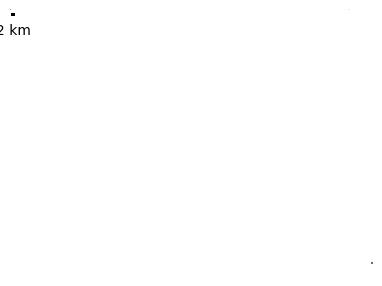

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


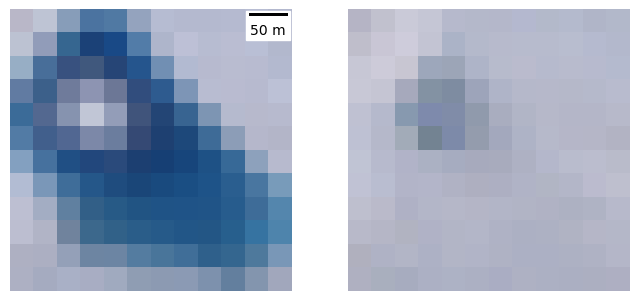

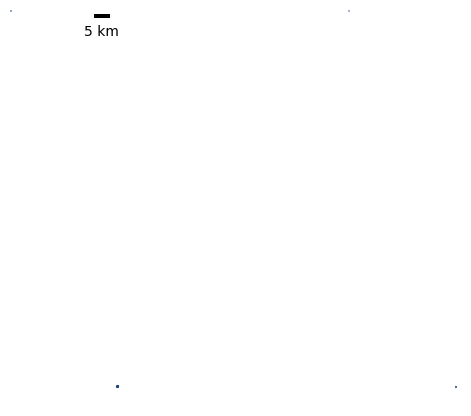

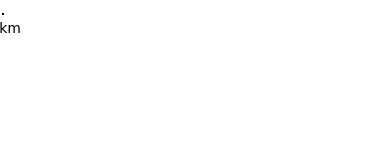

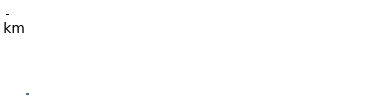

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


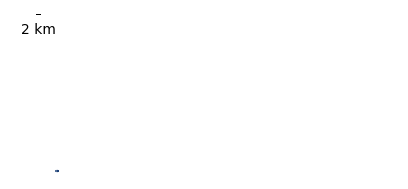

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


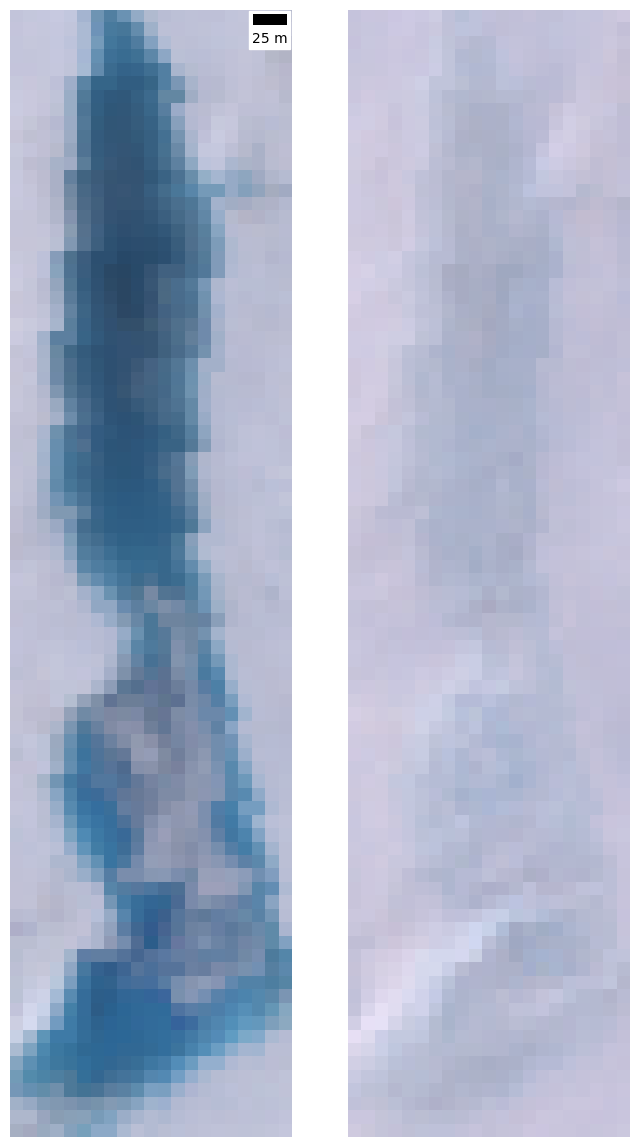

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


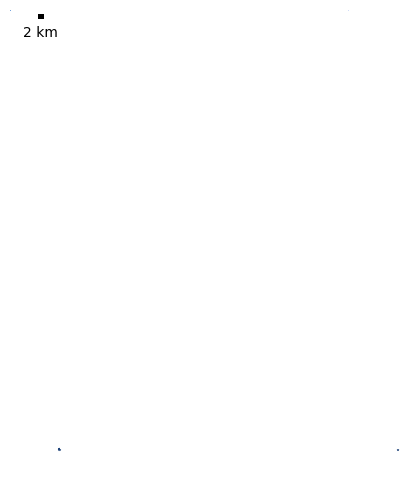

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


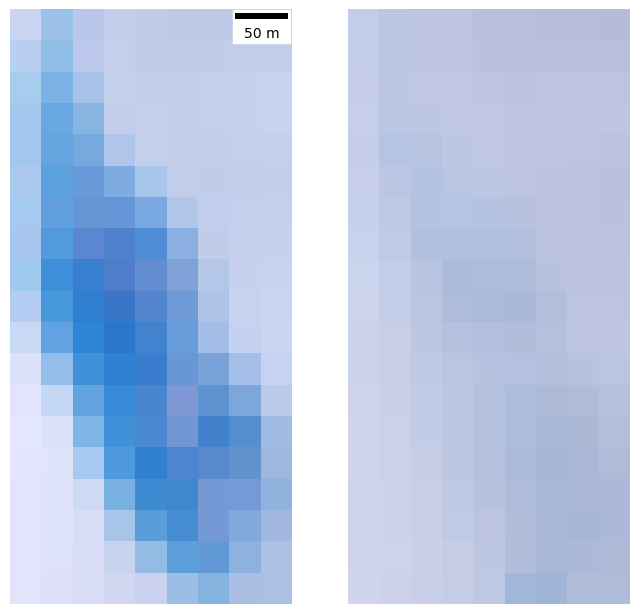

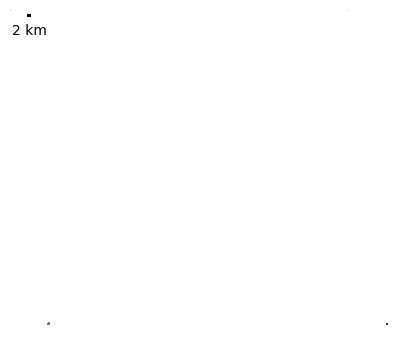

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


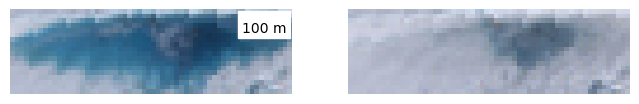

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1715078651.py:73: RuntimeWarning: Mean of empty slice
  mean_depth1.append(np.nanmean(tif1[2]))


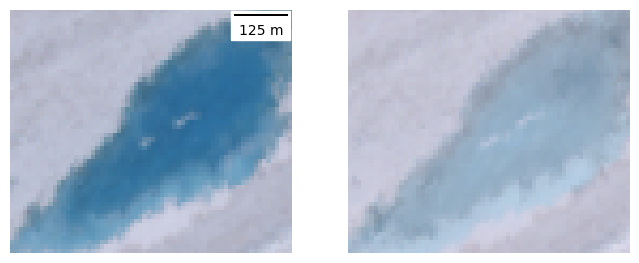

In [84]:
offset = 0
max_depth = 3
mean_depth0 = []
mean_depth1 = []
volume0 = []
volume1 = []
for i_criteria, criteria in enumerate(drains["criteria"].unique()):
    drainage = drains[drains["criteria"] == criteria]
    if drainage.shape[0] == 0:
        continue

    drainage0 = drainage[drainage["window"] == 0].dissolve()  # type: ignore
    minx = min(drainage0.bounds.minx) - offset
    miny = min(drainage0.bounds.miny) - offset
    maxx = max(drainage0.bounds.maxx) + offset
    maxy = max(drainage0.bounds.maxy) + offset
    dx = maxx - minx
    dy = maxy - miny

    w0 = sgl_utils.Window()
    w1 = sgl_utils.Window()
    if drainage["year"].iloc[0] == 18:
        w0 = [w for w in coll18.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-0"].iloc[0]][0]
        w1 = [w for w in coll18.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-1"].iloc[0]][0]
        with rasterio.open(os.path.join(settings18.season_folder, w0.file_rgb)) as src:
            rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb0_trans = src.transform
        with rasterio.open(os.path.join(settings18.season_folder, w0.file_reduced)) as src:
            tif0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif0_trans = src.transform
        with rasterio.open(os.path.join(settings18.season_folder, w1.file_rgb)) as src:
            rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb1_trans = src.transform
        with rasterio.open(os.path.join(settings18.season_folder, w1.file_reduced)) as src:
            tif1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif1_trans = src.transform
    elif  drainage["year"].iloc[0] == 19:
        w0 = [w for w in coll19.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-0"].iloc[0]][0]
        w1 = [w for w in coll19.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-1"].iloc[0]][0]
        with rasterio.open(os.path.join(settings19.season_folder, w0.file_rgb)) as src:
            rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb0_trans = src.transform
        with rasterio.open(os.path.join(settings19.season_folder, w0.file_reduced)) as src:
            tif0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif0_trans = src.transform
        with rasterio.open(os.path.join(settings19.season_folder, w1.file_rgb)) as src:
            rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb1_trans = src.transform
        with rasterio.open(os.path.join(settings19.season_folder, w1.file_reduced)) as src:
            tif1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif1_trans = src.transform
    elif drainage["year"].iloc[0] == 20:
        w0 = [w for w in coll20.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-0"].iloc[0]][0]
        w1 = [w for w in coll20.windows if w.name == drainage["name"].iloc[0] and w.metadata["date"] == drainage["date-1"].iloc[0]][0]
        with rasterio.open(os.path.join(settings20.season_folder, w0.file_rgb)) as src:
            rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb0_trans = src.transform
        with rasterio.open(os.path.join(settings20.season_folder, w0.file_reduced)) as src:
            tif0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif0_trans = src.transform
        with rasterio.open(os.path.join(settings20.season_folder, w1.file_rgb)) as src:
            rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            rgb1_trans = src.transform
        with rasterio.open(os.path.join(settings20.season_folder, w1.file_reduced)) as src:
            tif1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
            tif1_trans = src.transform
    else:
        print("error")
    
    
    mean_depth0.append(np.nanmean(tif0[2]))
    volume0.append(np.nansum(tif0[2]) * w0.res**2)
    mean_depth1.append(np.nanmean(tif1[2]))
    volume1.append(np.nansum(tif1[2]) * w1.res**2)

    img_size = 4
    fig, axes = plt.subplots(1, 2, figsize = (2 * img_size, img_size * dy / dx), sharex = True, sharey = True)
    axes_flat = np.ravel(np.array(axes))#
    
    ax = axes_flat[0]
    rplt.show(rgb0, transform = rgb0_trans, ax = ax)
    drainage0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    #ax.text(.01, .99, "a) " + lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | " + lake0["type"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    #ax.text(.01, .01, lake0["name"].iloc[0] + " | " + str(int(lake0["lake id"].iloc[0])), ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.add_artist(ScaleBar(1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax= axes_flat[1]
    rplt.show(rgb1, transform = rgb1_trans, ax = ax)
    if drainage["type"].iloc[0]  == "shrink":
        drainage1 = drainage[drainage["window"] == 1]
        drainage1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    #ax.text(.01, .99, "b) " + lake0["date-1"].iloc[0] + " | " + lake0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.show()

In [75]:

drains0 = drains[drains["window"] == 0]
exported_drains = pd.DataFrame()
exported_drains['lon'] = drains0.to_crs(settings.crs_wgs84_str).centroid.x
exported_drains['lat'] = drains0.to_crs(settings.crs_wgs84_str).centroid.y
exported_drains[["date-0", "sat-0", "start-0", "end-0"]] = drains0[["date-0", "sat-0", "start-0", "end-0"]]
exported_drains["meandepth-0 m"] = mean_depth0
exported_drains["volume-0 m^3"] = volume0
exported_drains[["date-1", "sat-1", "start-1", "end-1"]] = drains0[["date-1", "sat-1", "start-1", "end-1"]]
exported_drains["meandepth-1 m"] = mean_depth1
exported_drains["volume-1 m^3"] = volume1
exported_drains["volume-1 m^3"].replace(0, np.nan, inplace = True)

C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1218993627.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exported_drains['lon'] = drains0.to_crs(settings.crs_wgs84_str).centroid.x
C:\Users\js-ms\AppData\Local\Temp\ipykernel_6660\1218993627.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exported_drains['lat'] = drains0.to_crs(settings.crs_wgs84_str).centroid.y


In [77]:
exported_drains.to_csv(os.path.join(settings.region_folder, "shackleton_hydrofractures_JS.csv"))

In [79]:
exported_drains

,lon,lat,date-0,sat-0,start-0,end-0,meandepth-0 m,volume-0 m^3,date-1,sat-1,start-1,end-1,meandepth-1 m,volume-1 m^3
0,97.781752,-66.594966,2018-12-26,S2,2018-12-21,2018-12-31,0.633600,80023.718262,2019-01-05,S2,2018-12-31,2019-01-10,NaN,NaN
1,98.847890,-66.359584,2019-01-30,L8,2019-01-26,2019-02-03,0.822360,82153.784180,2019-02-07,L8,2019-02-03,2019-02-11,0.532670,6711.637974
2,98.869408,-66.358789,2019-02-14,S2,2019-02-09,2019-02-19,0.510675,51016.455078,2019-02-24,S2,2019-02-19,2019-03-01,0.302225,3928.926849
5,100.561561,-66.214001,2019-12-16,S2,2019-12-11,2019-12-21,1.557963,118716.748047,2019-12-26,S2,2019-12-21,2019-12-31,NaN,NaN
6,100.476880,-66.153186,2020-01-22,L8,2020-01-18,2020-01-26,1.774462,134149.356079,2020-01-30,L8,2020-01-26,2020-02-03,NaN,NaN
7,98.493578,-65.782618,2020-01-05,S2,2019-12-31,2020-01-10,0.583205,30501.635742,2020-01-15,S2,2020-01-10,2020-01-20,NaN,NaN
8,99.719303,-66.264245,2020-01-06,L8,2020-01-02,2020-01-10,0.906136,57902.075958,2020-01-14,L8,2020-01-10,2020-01-18,0.448999,3636.890888
9,99.944338,-66.447642,2020-01-06,L8,2020-01-02,2020-01-10,0.805293,60880.133057,2020-01-14,L8,2020-01-10,2020-01-18,0.365867,1646.403515
10,99.855341,-66.446568,2020-01-22,L8,2020-01-18,2020-01-26,1.618117,112135.487366,2020-01-30,L8,2020-01-26,2020-02-03,NaN,NaN
11,98.870325,-66.357777,2020-01-22,L8,2020-01-18,2020-01-26,0.767080,71798.723602,2020-01-30,L8,2020-01-26,2020-02-03,0.676679,7308.135509
